# Laplace's Equations in 2 Dimensions

## Author
James John 

## Purpose
To demonstrate understanding of electrostatics physics and computational modeling by solving Laplace's Equations in 2 dimension both numerically and analytically 

## Goals 
- Derive Laplace's Equations from Maxwell's Equations in 2 D 
- Derive analytical solutions for a 2 D case
- Create a finite-difference numerical solver for 2D-Laplace's Equation
- Comparison between analytical and numerical solutions
- Visualizations of potential and electric fields

## Derivation of Laplace's Equation from Maxwell's Equations

We start from **Maxwell's equations** in differential form (in vacuum):

$$
\nabla \cdot \mathbf{E} = \frac{\rho}{\varepsilon_0}, \qquad
\nabla \times \mathbf{E} = -\frac{\partial \mathbf{B}}{\partial t}.
$$

For *electrostatic* conditions, the fields are time-independent, so

$$
\frac{\partial \mathbf{B}}{\partial t} = 0 \quad \Rightarrow \quad \nabla \times \mathbf{E} = 0.
$$

A vector field with zero curl can be written as the negative gradient of a scalar potential $V(r)$ such that:

$$
\mathbf{E} = -\nabla V.
$$

Substitute into Gauss's law:

$$
\nabla \cdot \mathbf{E} = \nabla \cdot (-\nabla V) = -\nabla^2 V = \frac{\rho}{\varepsilon_0}.
$$

This is **Poisson's equation**:

$$
\nabla^2 V = -\frac{\rho}{\varepsilon_0}.
$$

In a region with no free charge $(\rho = 0)$, we obtain **Laplace's equation**:

$$
\boxed{\nabla^2 V = 0.}
$$

## Analytical solution: 2-D Laplace's equation on a rectangle (separation of variables)

We solve Laplace’s equation on a rectangular domain $0<x<a,\;0<y<b$:
$$
\nabla^2 V = \frac{\partial^2 V}{\partial x^2} + \frac{\partial^2 V}{\partial y^2} = 0,
$$
with homogeneous Dirichlet boundary conditions on three sides and a prescribed function on the remaining side. A common and convenient choice (which leads to a single Fourier series in $x$ is
$$
V(x,0) = f(x)\quad\text{(bottom)},\qquad 
V(x,b)=0,\quad V(0,y)=0,\quad V(a,y)=0.
$$

### Separation of variables
Assume a product solution $V(x,y)=X(x)\,Y(y)$. Substituting into Laplace’s equation and separating gives
$$
\frac{X''(x)}{X(x)} = -\frac{Y''(y)}{Y(y)} = -\lambda,
$$
with separation constant $\lambda\ge 0$. The $x$-equation with homogeneous Dirichlet ends yields sine eigenfunctions:
$$
X_n(x) = \sin\!\big(\tfrac{n\pi x}{a}\big),\qquad \lambda_n = \left(\tfrac{n\pi}{a}\right)^2,\quad n=1,2,\dots
$$
The corresponding $y$-equation is
$$
Y_n''(y) - \lambda_n Y_n(y) = 0,
$$
with general solutions 
$$Y_n(y) = A_n\sinh(\sqrt{\lambda_n}y) + B_n\cosh(\sqrt{\lambda_n}y).
$$
Imposing $V(x,b)=0$ and combining constants yields the mode shape in $y$ proportional to:
$$
\frac{\sinh\!\big(\sqrt{\lambda_n}(b-y)\big)}{\sinh\!\big(\sqrt{\lambda_n}b\big)}
$$.

### Series solution
The full solution satisfying the three zero boundaries and matching $V(x,0)=f(x)$ is the Fourier sine series
$$
\boxed{%
V(x,y)=\sum_{n=1}^{\infty} A_n\,\sin\!\Big(\frac{n\pi x}{a}\Big)\,\frac{\sinh\!\big(\gamma_n (b-y)\big)}{\sinh(\gamma_n b)}%
}
$$
where
$$
\gamma_n=\frac{n\pi}{a},
$$
and the Fourier coefficients, $A_n$, are given by the sine-orthogonality integral on $[0,a]$:


$$
A_n = \frac{2}{a} \int_0^a f(x)\sin\!\left(\frac{n\pi x}{a}\right)\,dx 
= \frac{2f(x)}{n\pi} \left(1 - \cos(n\pi)\right)
$$



## Display of Analytical Solution 

In [1]:
# Import all needed libraries
import numpy as np
import matplotlib.pyplot as plt
from time import time
from matplotlib.colors import Normalize

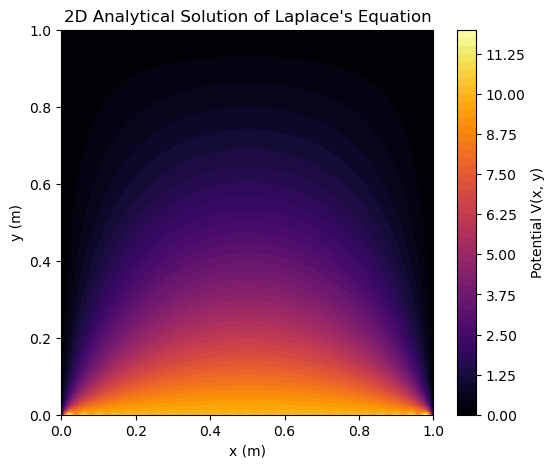

In [2]:
# Geometry and boundary conditions 
a = 1.0                   # width in m (x-direction)
b = 1.0                   # height in m (y-direction)
Nx = 101                  # number of points in x direction 
Ny = 101                  # number of points in the y direction 
def f(x): return  10      # potential at V(x,0) for the bottom (V)
N_terms = 50              # number of terms to include in our fourier series 

# Create an x and y array from 0 to a or b with N number of points
x = np.linspace(0, a, Nx)
y = np.linspace(0, b, Ny)
# Create a 2D array of the x and y values 
X, Y = np.meshgrid(x, y)

# create an array from 1 to N_terms incrememting by 1 
n = np.arange(1,N_terms + 1, 1)
# create an array of A_n values using the analytic solution 
A_n = (2 * f(x) / (n * np.pi)) * (1 - np.cos(n * np.pi))

# Create an array for the potential that has the same shape as X, Y
V_exact = np.zeros_like(X)

# Do a sum of the Fourier Series for V
for i in range(N_terms):        
    for j in range(Ny):  # loop over rows (y-direction)
        for k in range(Nx):  # loop over columns (x-direction)
            # Use analytic solution for V(x,y)
            V_exact[j, k] += A_n[i] * np.sin(n[i] * np.pi * X[j, k] / a) * np.sinh(n[i] * np.pi * (b - Y[j, k]) / a) / np.sinh(n[i] * np.pi * b / a)

# Plot
plt.figure(figsize=(6,5))
contour = plt.contourf(X, Y, V_exact, levels=50, cmap='inferno')
plt.colorbar(contour, label='Potential V(x, y)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('2D Analytical Solution of Laplace\'s Equation')
plt.show()

## Numerical Solution: Jacobi Iteration for Laplace’s Equation (2D)

We are now going to solve Laplace's Equation in 2D with Jacobi Iterations:

$$
\nabla^2 V(x, y) =
\frac{\partial^2 V}{\partial x^2}
+
\frac{\partial^2 V}{\partial y^2}
= 0.
$$

We discretize a rectangular domain  
$$ x \in [0, L_x] $, $ y \in [0, L_y] $$
into a uniform grid with $ N_x $ points in the $x$-direction and $ N_y $ points in the $y$-direction:

$$
x_i = i\,\Delta x, \quad y_j = j\,\Delta y,
$$

where

$$
\Delta x = \frac{L_x}{N_x - 1}, \quad
\Delta y = \frac{L_y}{N_y - 1}.
$$

Using central differences for both second derivatives, Laplace’s equation becomes

$$
\frac{V_{i+1,j} - 2V_{i,j} + V_{i-1,j}}{(\Delta x)^2}
+
\frac{V_{i,j+1} - 2V_{i,j} + V_{i,j-1}}{(\Delta y)^2}
= 0.
$$

For a square grid where $ \Delta x = \Delta y $, this simplifies to the Jacobi update rule:

$$
V_{i,j}^{(new)} =
\frac{1}{4}
\left(
V_{i+1,j}^{(old)} +
V_{i-1,j}^{(old)} +
V_{i,j+1}^{(old)} +
V_{i,j-1}^{(old)}
\right).
$$

At each iteration, all interior grid points are updated using values from the previous iteration, while the boundary values are held fixed according to the specified boundary conditions:

$$
V(x, y) \big|_{\text{boundary}} = \text{given}.
$$

The iteration continues until the solution converges, defined by the maximum change between successive iterations falling below a chosen tolerance:

$$
\max_{i,j}
\left|
V_{i,j}^{(new)} - V_{i,j}^{(old)}
\right|
< \text{tol}.
$$

The final result is a numerical approximation to the potential $ V(x, y) $ that satisfies Laplace’s equation over the 2D domain with the imposed boundary conditions.

In [3]:
# Define a fucntion which has a nonzero initial potential on the bottom surface
def bottom_potential_grid(Nx, Ny, a, b, V_0):
    """Create grid arrays X,Y and an initial potential on the bottom surface:
       bottom (y=0) = V_0, top and sides = 0.
       Nx, Ny = number of grid points
       a, b = side lengths of surface
       V_0 = the potential on the bottom surface 
    """
    # Create X and Y arrays 
    x = np.linspace(0, a, Nx)
    y = np.linspace(0, b, Ny)
    X, Y = np.meshgrid(x, y)
    # Set an initial V array to zero
    V = np.zeros((Ny, Nx))
    # Enforce boundary conditions 
    V[0, :] = V_0      # bottom row (y=0) 
    V[-1, :] = 0.0     # top row
    V[:, 0] = 0.0      # left column
    V[:, -1] = 0.0     # right column

    # Return X, Y, and V arrays 
    return X, Y, V

# Define a fucntion which has a nonzero initial potential on the bottom surface
def bottom_right_potential_grid(Nx, Ny, a, b, V_0):
    """Create grid arrays X,Y and an initial potential on the bottom surface:
       bottom (y=0) = V_0, top and sides = 0.
       Nx, Ny = number of grid points
       a, b = side lengths of surface
       V_0 = the potential on the bottom surface 
    """
    # Create X and Y arrays 
    x = np.linspace(0, a, Nx)
    y = np.linspace(0, b, Ny)
    X, Y = np.meshgrid(x, y)
    # Set an initial V array to zero
    V = np.zeros((Ny, Nx))
    # Enforce boundary conditions 
    V[0, :] = V_0      # bottom row (y=0) 
    V[-1, :] = V_0     # top row
    V[:, 0] = 0.0      # left column
    V[:, -1] = 0.0     # right column

    # Return X, Y, and V arrays 
    return X, Y, V

# Define a function which numerically solves the potential using Jacobi iterations 
def jacobi_2d_loops(V, max_iter=20000, tol=1e-4, verbose=True):
    """Simple Jacobi iteration on array V (BCs assumed already set).
       V is a 2D array of zeros with BC already set 
       Returns (V, iters, converged, elapsed_seconds).
    """
    # set Nx and Ny from the shape of input V
    Ny, Nx = V.shape
    # create a new copy of V 
    V_new = V.copy()
    # set inital time
    t0 = time()

    # Start iteration loops 
    for i in range(1, max_iter+1):
        # Loop through columns of the V array 
        for j in range(1, Ny-1):
            for k in range(1, Nx-1):
                # apply jacobi iterations rule for a 2D system 
                V_new[j, k] = 0.25 * (V[j, k+1] + V[j, k-1] + V[j+1, k] + V[j-1, k])
                
        # solve for the maximum difference in the arrays 
        diff = np.max(np.abs(V_new - V))
        # copy back into V
        V[:, :] = V_new  

        # if verbose is set to true, print out information every 500 iterations 
        if verbose and (i % 500 == 0):
            print(f"Jacobi iter {i}, max diff = {diff:.3e}")

        # if the difference is less than tolerance
        if diff < tol:
            # record final time 
            t1 = time()
            # exit function and return final V array and convergence info 
            return V, i, True, t1 - t0

    # If loop ends and V has not converged 
    # return final time 
    t1 = time()
    # still return v, but convergence info returns false
    return V, max_iter, False, t1 - t0

In [4]:
# set up boundary conditions similar to analytical 
Nx, Ny = 101, 101
V_0 = 10.0
a = 1
b = 1 
X, Y, V_init = bottom_potential_grid(Nx, Ny, a, b, V_0)

# run the Jacobi iterations
V_num, iters, conv, elapsed = jacobi_2d_loops(V_init, max_iter=20000, tol=1e-4, verbose=True)

# show how long it took and how many iterations required 
print(f"Nested-loop Jacobi: iters={iters}, converged={conv}, time={elapsed:.3f}s")


Jacobi iter 500, max diff = 4.824e-03
Jacobi iter 1000, max diff = 2.296e-03
Jacobi iter 1500, max diff = 1.394e-03
Jacobi iter 2000, max diff = 9.342e-04
Jacobi iter 2500, max diff = 6.634e-04
Jacobi iter 3000, max diff = 4.889e-04
Jacobi iter 3500, max diff = 3.692e-04
Jacobi iter 4000, max diff = 2.831e-04
Jacobi iter 4500, max diff = 2.191e-04
Jacobi iter 5000, max diff = 1.704e-04
Jacobi iter 5500, max diff = 1.328e-04
Jacobi iter 6000, max diff = 1.036e-04
Nested-loop Jacobi: iters=6073, converged=True, time=46.569s


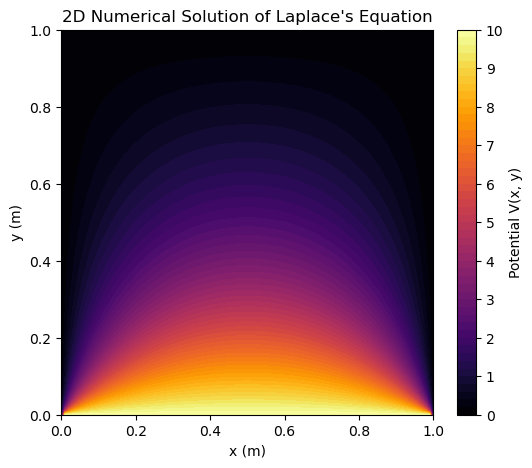

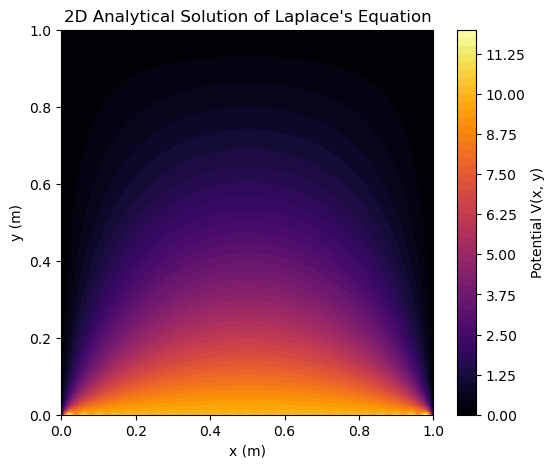

In [5]:
norm = Normalize(0,10)
ticks = np.linspace(0,10,11)

# Plot Numerical
plt.figure(figsize=(6,5))
contour1 = plt.contourf(X, Y, V_num, levels=50, cmap='inferno', vmin=0, vmax = 10 )
plt.colorbar(contour1, label='Potential V(x, y)', ticks=ticks)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('2D Numerical Solution of Laplace\'s Equation')
plt.show()

# Plot analytical 
plt.figure(figsize=(6,5))
contour = plt.contourf(X, Y, V_exact, levels=50, cmap='inferno')
plt.colorbar(contour, label='Potential V(x, y)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('2D Analytical Solution of Laplace\'s Equation')
plt.show()


## Discussion

This is a significantly more complex numerical problem than the 1D case. The numerical solution converges well and closely matches the analytical solution, which confirms that the Jacobi method is being implemented correctly.

One noticeable discrepancy is that the analytical solution ends up exceeding the imposed boundary potential. This occurs due to the truncation of the Fourier series used to construct the analytical solution. In contrast, the numerical solution strictly enforces the boundary conditions at each iteration, resulting in values that remain physically consistent with the specified boundaries. In this sense, the numerical solution can be considered more representative of the intended boundary conditions.

In this implementation, the solver only applies a potential along one boundary (the bottom edge of the domain). However, the code structure makes it straightforward to extend this to include fixed potentials on any boundary. It can even be constructed to have a function as a boundary condition. This highlights one of the major strengths of numerical solvers: they allow us to solve problems with complex or arbitrary boundary conditions that would be extremely difficult, or impossible, to handle analytically.
